In [1]:
import torch
import Trainer
from network import NFM
import torch.utils.data as Data
from Utils.criteo_loader import getTestData, getTrainData

nfm_config = \
{
    'n_class':9,
    'linear_hidden1':2000,
    #'linear_hidden':100,#线性模型输出层（隐层个数）
    #'embed_input_dim':1001,#embed输入维度
    #'embed_dim': 100, # 用于控制稀疏特征经过Embedding层后的稠密特征大小，embed输出维度
    #'dnn_hidden_units': [100,11],#MLP隐层和输出层
    
    'dnn_hidden_units':[100,8],#MLP隐层
    'num_sparse_features_cols':10477,#the number of the gene columns
    'num_dense_features': 0,#dense features number
    'bi_dropout': 0.5,#Bi-Interaction 的dropout
    'num_epoch': 500,#训练epoch次数
    'batch_size': 16,#batch_size
    'lr': 1e-3,
    'l2_regularization': 1e-4,
    'device_id': 0,
    'use_cuda': False,
    'epoch':1000,
    
    #'train_file': '../Data/criteo/processed_data/train_set.csv',
    #'fea_file': '../Data/criteo/processed_data/fea_col.npy',
    #'validate_file': '../Data/criteo/processed_data/val_set.csv',
    #'test_file': '../Data/criteo/processed_data/test_set.csv',
    #'model_name': '../TrainedModels/NFM.model'
    #'train_file':'data/xiaoqiu_gene_5000/train/final_5000_encode_100x.csv',
    #'train_data':'dataset/qiuguan/encode/encode_1000/train/train_encode_data_1000_new.csv',
    #'train_label':'dataset/qiuguan/non_code/train/train_label.csv',
    #'guan_test_data':'dataset/qiuguan/non_code/guan_test/guan_test_data.csv',
    #'guan_test_label':'dataset/qiuguan/non_code/guan_test/guan_test_label.csv',
    #'test_data':'dataset/qiuguan/encode/encode_1000/test/test_encode_data_1000_new.csv',
    #'test_label':'dataset/qiuguan/non_code/test/test_labels.csv',
    #'title':'dataset/xiaoguan/RF/RF_for_train/train_class_9/test/test_data.csv',
    'gene_name':'dataset/qiuguan/origin_800/gene_name.csv',
    'label_name':'dataset/qiuguan/origin_800/gene_label.csv'
    #'all':''
    #'title':'data/xiaoqiu_gene_5000/train/gene_5000_gene_name.csv',
    #'all':'data/xiaoqiu_gene_5000/train/gene_5000_label_name.csv'
}
#model definition
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model = MLP().cuda()
print(model)

import os
import time
import argparse
import numpy as np
import pandas as pd 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn
#3from tensorboardX import SummaryWriter
import torch.nn.functional as F  # 激励函数的库
#import network
import config
import evaluate
import data_utils
#import Trainer

def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    #n = len(labels)
    n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output

def one_hot(labels, classes):
    n = len(labels)
    #eoff = label_smoothing / classes
    output = np.zeros((n, classes), dtype=np.float32)
    for row, label in enumerate(labels):
        output[row, label] = 1
        #print("row:",row,"label:",label)
    return output


import pandas as pd 

from sklearn.model_selection import train_test_split




def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    #n = len(labels)
    n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output

def one_hot(labels, classes):
    n = len(labels)
    #eoff = label_smoothing / classes
    output = np.zeros((n, classes), dtype=np.float32)
    for row, label in enumerate(labels):
        output[row, label] = 1
        #print("row:",row,"label:",label)
    return output

class KZDatasetTest(data.Dataset):
    """ Construct the FM pytorch dataset. """
    #def __init__(self, file,label_file, feature_map,n_class=16):
    def __init__(self, csv_path):
    
        self.data_info = self.get_data_info(csv_path)
        
        
            
        
        
        

    def __getitem__(self, index):
        # Dataset读取图片的函数
        data, label = self.data_info[index]
        #img = Image.open(img_pth).convert('RGB')
        
        return data, label

    def __len__(self):
        return len(self.data_info)
    
    
    
    def get_data_info(self,csv_path):
        #解析路径
        #转为一维list存储，每一位为【图片路径，图片类别】
        labels=[]
        data_info=[]
        df=pd.read_csv(csv_path,sep=',',header=None)
        
        df=df.iloc[1:,1:]
        #print("df:",df)
        #print(df.iloc[:,-1])
        #df=df.applymap(ast.literal_eval)
        rows,cols=df.shape
        #print(rows,cols)
        for i in df.iloc[:,-1]:
            #print(i)
            labels.append(int(i))
        #print('labels:',labels)
        labels=np.array(labels)
        #print('labels:',labels)
        #labels=np.array(labels)
        labels=one_hot_smoothing(labels,nfm_config['n_class'])
        #print(labels)
        for i in range(rows):
            data=df.iloc[i,:-1]
            data=data.astype(float)##############
            #print("i,data:",i,data)
            #data=pd.DataFrame(data,dtype=float)###############
            data=np.array(data)##
            
            label=labels[i]
            #print(data.shape)
            #print(label.shape)
            #label=label.tolist()
            data=torch.from_numpy(data)#
            label=torch.from_numpy(label)#
           
            
            data_info.append((data,label))
        return data_info
    
    
    
    
import torch
import torch.nn as nn
from torch.utils.data.dataset import *
from PIL import Image
from torch.nn import functional as F
import random
from sklearn.model_selection import train_test_split
import ast
import torchvision

MLP(
  (bn0): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3300, out_features=2000, bias=True)
  (bn1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2000, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)


In [2]:
#######找特征基因#############从3301中找200个基因
#########################################################本次测试的目的是看200个基因的分类效果
##########测试步骤：从3301个基因中提取350个
############用200个构建新的分类模型
#################特征基因
######################为小球，根据上边的测试的基因个数，350最大
import torch

import torch.nn as nn
import torch.optim as optim


from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from mnist_test import Net, train, test


# Network parameters
class Params(object):
    batch_size = 64
    test_batch_size = 20
    epochs = 5
    lr = 0.01
    momentum = 0.5
    no_cuda = True
    seed = 1
    log_interval = 10
    
    def __init__(self):
        pass

args = Params()
torch.manual_seed(args.seed)
#device = torch.device("cpu")
device=torch.device('cuda')
kwargs = {}



##############数据准备
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
#功能：加载保存到path中的各层参数到神经网络

path='dataset/qiuguan/origin_800/non_encode_aug/para0.4_0.6_0/MLP10210.pkl'

#nfm=NFM(nfm_config)
mlp=MLP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
mlp.load_state_dict(torch.load(path),strict=False)
mlp.cuda()

print(mlp)




mlp_params = list(mlp.named_parameters())
#print(nfm_params)
net=mlp
model=net###########
'''
testset = KZDatasetTest(csv_path='../NFM-pyorch-master/dataset/qiuguan/orign/')
   
test_loader = DataLoader(
         dataset=testset,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size']
        
     )
'''

testset_xiaoqiu  = KZDatasetTest(csv_path='dataset/qiuguan/origin_800/xiaoqiu/test_info.csv')#样本收集特征数据集，和测试数据集不同，这里边可能还包含训练集
   
test_loader_xiaoqiu = DataLoader(
         dataset=testset_xiaoqiu,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size'],
         shuffle=True
        
     )

testset_xiaoguan  = KZDatasetTest(csv_path='dataset/qiuguan/origin_800/xiaoguan/test_info.csv')
   
test_loader_xiaoguan = DataLoader(
         dataset=testset_xiaoguan,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size'],
         shuffle=True
        
     )

################小球

#LRP
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

from innvestigator import InnvestigateModel
from utils import Flatten


inn_model = InnvestigateModel(model, lrp_exponent=2,
                              method="e-rule",
                              beta=.5)

genes_features=np.array([i for i  in range(9)])#################
genes_features=genes_features.reshape(9,1).tolist()#######################genes_features[i][0]=label



###[3, 25.353026075712233, tensor([ 182,  879,  103, 2657, 2489,  914, 2437,  180, 2417, 1402, 2344, 2947,
###values=tensor([0.0572, 0.0495, 0.0404, 0.0381, 0.0364, 0.0353, 0.0328, 0.0302, 0.0284,
#        0.0257, 0.0180, 0.0164, 0.0155, 0.0150, 0.0135, 0.0127, 0.0121, 0.0120,
#        0.0114, 0.0107, 0.0107, 0.0104, 0.0100, 0.0100, 0.0099, 0.0091, 0.0091,
#       0.0088, 0.0083, 0.0082, 0.0081, 0.0079, 0.0078, 0.0077, 0.0076, 0.0074,
#       0.0073, 0.0072, 0.0072, 0.0071], dtype=torch.float64),
###indices=tensor([ 182,  879,  103, 2657, 2489,  914, 2437,  180, 2417, 1402, 2344, 2947,
#        2546, 1114,  796, 1111, 2472, 2326, 1274,  932, 2476,  716,  989, 3289,
#        1252, 2053,  785, 2429, 3015, 1585,  975, 1150, 1155,  726,  823, 2303,
#         699,  349, 1792, 1524])), 25.359040192320702, tensor([2489,  826, 1753, 1792,  601, 2303, 1053,  545, 2559,  624, 3256,  762,
#        2666,  182, 1881, 1585,  726, 1367, 2405, 1171, 2947, 2093,   14,  265,
#         716,  180, 1467, 2207, 3223,  349,  277, 2141, 2878, 2427, 2326, 1111,
#         746, 1402, 2150, 1602]), torch.return_types.topk(
#values=tensor([0.0456, 0.0445, 0.0406, 0.0349, 0.0277, 0.0273, 0.0246, 0.0236, 0.0225,
#        0.0221, 0.0213, 0.0200, 0.0185, 0.0182, 0.0181, 0.0153, 0.0151, 0.0142,
##        0.0141, 0.0140, 0.0138, 0.0123, 0.0121, 0.0115, 0.0109, 0.0108, 0.0107,
#        0.0102, 0.0102, 0.0098, 0.0094, 0.0093, 0.0092, 0.0089, 0.0082, 0.0081,
#        0.0080, 0.0080, 0.0079, 0.0076], dtype=torch.float64),
#indices=tensor([2489,  826, 1753, 1792,  601, 2303, 1053,  545, 2559,  624, 3256,  762,
#        2666,  182, 1881, 1585,  726, 1367, 2405, 1171, 2947, 2093,   14,  265,
#         716,  180, 1467, 2207, 3223,  349,  277, 2141, 2878, 2427, 2326, 1111,
#         746, 1402, 2150, 1602]))]
model.double()
for data, target in test_loader_xiaoqiu:############小球

    data, target = data.to(device), target.to(device)
    #targets=torch.max(targets,1)[1]###################
    #print('data:',data.shape)
    batch_size = int(data.size()[0])
    #print('batch_size:',batch_size)#=20
    evidence_for_class = []
    #print("target:",target.shape)
    #print('target:',target[3])
    # Overlay with noise 
    # data[0] += 0.25 * data[0].max() * torch.Tensor(np.random.randn(28*28).reshape(1, 28, 28))
    #model_prediction, true_relevance = inn_model.innvestigate(in_tensor=data)

    for i in range(9):#10类
    # Unfortunately, we had some issue with freeing pytorch memory, therefore 
    # we need to reevaluate the model separately for every class.
        model_prediction, input_relevance_values = inn_model.innvestigate2(in_tensor=data, rel_for_class=i,target=target)
        evidence_for_class.append(input_relevance_values)
    #print('input_relevance_values:',input_relevance_values.shape)
    #print('evidence_for_class:',len(evidence_for_class))
    evidence_for_class = np.array([elt.numpy() for elt in evidence_for_class])
    #print('evidence_for_class:',evidence_for_class.shape)#[10,20,784]
    for idx, example in enumerate(data):#batch 中的每一个样本
        #print('example:',example.shape)
        prediction = np.argmax(model_prediction.cpu().detach(), axis=1)#
        #print('prediction[idx]:',prediction[idx])
        #print(evidence_for_class[prediction[idx]][idx])
        #fig, axes = plt.subplots(3, 5)
        '''
        fig.suptitle("Prediction of model: " + str(prediction[idx]) + "({0:.2f})".format(
            100*float(model_prediction[idx][model_prediction[idx].argmax()].exp()/model_prediction[idx].exp().sum())))
        '''
        prediction_value=prediction[idx]
        p_x=model_prediction[idx][model_prediction[idx].argmax()].exp()
        p_sum=model_prediction[idx].exp().sum()
        prediction_score=100*float(model_prediction[idx][model_prediction[idx].argmax()].exp()/model_prediction[idx].exp().sum())
        #print('prediction_value:',prediction_value)
        #print('prediction_score:',prediction_score)
        #print('分子:',p_x)
        #print('分母：',p_sum)
        #uu=pr
        #print("torch.argmax:",torch.argmax(target[idx]))
        if len(genes_features[prediction_value])==1:#有值，但还没有添加预测分数和特征值，只有标签#prediction_value代表第几种疾病
            if prediction_value!=torch.argmax(target[idx]).cpu().detach()  :
                print('不合格****************:',prediction_value)
            if prediction_value==torch.argmax(target[idx]).cpu().detach()  :#预测正确
                genes_features[prediction_value].append(prediction_score)
                print('合格：',prediction_value)
                relevance_score_for_every_pixel=evidence_for_class[prediction[idx]][idx]
                #print('relevance_score_for_every_pixel.shape:',relevance_score_for_every_pixel.tolist())
                relevance_score_for_every_pixel=torch.from_numpy(relevance_score_for_every_pixel)
                index=torch.topk(relevance_score_for_every_pixel,50,largest=True)#基因个数50#####150
                #print('pixel_sorted:',index)
                genes_features[prediction_value].append(index.indices)#添加前50基因特征
                genes_features[prediction_value].append(index)
        else: 
            if genes_features[prediction_value][1]<prediction_score:#如果值比已有值大，说明预测更准确
                if prediction_value==torch.argmax(target[idx]).cpu().detach():
                    print('&&&&&&&&&&&&&&&&&&&合   格&&&&&&&&&&&&&&:',prediction_value)
                    genes_features[prediction_value].pop(3)#删除index
                    genes_features[prediction_value].pop(2)#先删除特征值
                    genes_features[prediction_value].pop(1)#先删除预测分数
                
                    genes_features[prediction_value].append(prediction_score)
        
                    relevance_score_for_every_pixel=evidence_for_class[prediction[idx]][idx]
                    #print('relevance_score_for_every_pixel.shape:',relevance_score_for_every_pixel.tolist())
                    relevance_score_for_every_pixel=torch.from_numpy(relevance_score_for_every_pixel)
                    index=torch.topk(relevance_score_for_every_pixel,50,largest=True)#基因个数50  200
                    #print('pixel_sorted:',index)
                    genes_features[prediction_value].append(index.indices)
                    genes_features[prediction_value].append(index)
print('qiu_____genes_features.shape:',genes_features)

MLP(
  (bn0): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3300, out_features=2000, bias=True)
  (bn1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2000, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)
relevance
torch.argmax(predict): tensor(1, device='cuda:0')
torch.argmax(predict): tensor(8, device='cuda:0')
torch.argmax(predict): tensor(3, device='cuda:0')
torch.argmax(predict): tensor(0, device='cuda:0')
torch.argmax(predict): tensor(2, device='cuda:0')
torch.argmax(predict): tensor(5, device='cuda:0')
torch.argmax(predict): tensor(6, device='cuda:0')
torch.argmax(predict): tensor(4, device='cuda:

torch.argmax(predict): tensor(7, device='cuda:0')
torch.argmax(predict): tensor(7, device='cuda:0')
torch.argmax(predict): tensor(1, device='cuda:0')
torch.argmax(predict): tensor(4, device='cuda:0')
torch.argmax(predict): tensor(7, device='cuda:0')
torch.argmax(predict): tensor(2, device='cuda:0')
torch.argmax(predict): tensor(8, device='cuda:0')
torch.argmax(predict): tensor(1, device='cuda:0')
torch.argmax(predict): tensor(8, device='cuda:0')
torch.argmax(predict): tensor(8, device='cuda:0')
torch.argmax(predict): tensor(0, device='cuda:0')
torch.argmax(predict): tensor(4, device='cuda:0')
torch.argmax(predict): tensor(7, device='cuda:0')
torch.argmax(predict): tensor(2, device='cuda:0')
torch.argmax(predict): tensor(8, device='cuda:0')
torch.argmax(predict): tensor(7, device='cuda:0')
torch.argmax(predict): tensor(7, device='cuda:0')
torch.argmax(predict): tensor(7, device='cuda:0')
torch.argmax(predict): tensor(1, device='cuda:0')
torch.argmax(predict): tensor(4, device='cuda:0')


torch.argmax(predict): tensor(7, device='cuda:0')
torch.argmax(predict): tensor(2, device='cuda:0')
torch.argmax(predict): tensor(6, device='cuda:0')
torch.argmax(predict): tensor(8, device='cuda:0')
torch.argmax(predict): tensor(1, device='cuda:0')
torch.argmax(predict): tensor(2, device='cuda:0')
torch.argmax(predict): tensor(0, device='cuda:0')
torch.argmax(predict): tensor(2, device='cuda:0')
torch.argmax(predict): tensor(6, device='cuda:0')
torch.argmax(predict): tensor(5, device='cuda:0')
torch.argmax(predict): tensor(8, device='cuda:0')
torch.argmax(predict): tensor(0, device='cuda:0')
torch.argmax(predict): tensor(4, device='cuda:0')
torch.argmax(predict): tensor(4, device='cuda:0')
torch.argmax(predict): tensor(8, device='cuda:0')
torch.argmax(predict): tensor(7, device='cuda:0')
torch.argmax(predict): tensor(7, device='cuda:0')
torch.argmax(predict): tensor(2, device='cuda:0')
torch.argmax(predict): tensor(6, device='cuda:0')
torch.argmax(predict): tensor(8, device='cuda:0')


In [3]:
import pickle
'''
my_dict = { 'Apple': 4, 'Banana': 2, 'Orange': 6, 'Grapes': 11}
# 保存文件
with open("myDictionary.pkl", "wb") as tf:
    pickle.dump(my_dict,tf)
# 读取文件
with open("myDictionary.pkl", "rb") as tf:
    new_dict = pickle.load(tf)

print(new_dict.items())

'''

#————————————————
#版权声明：本文为CSDN博主「HiJack¹」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
#原文链接：https://blog.csdn.net/Jialins_blog/article/details/122655536


#按字典保存，为了随后画热图

with open("dataset/qiuguan/origin_800/LRP_aug/50/qiu_genes_score_dict.pkl", "wb") as tf:
    for i in range(9):
    
        qiu_genes_dict=genes_features[i][3]
        #print(i)
        qiu_genes_values=qiu_genes_dict.values
        qiu_genes_indices=qiu_genes_dict.indices
        
        qiu_dict=dict(zip(qiu_genes_indices,qiu_genes_values))
        #print(qiu_genes_dict)
    
        pickle.dump(qiu_dict,tf)

In [7]:
###########如果不能为每个疾病找到特征基因，就反复点击这段代码，直到找到为止
testset_xiaoguan  = KZDatasetTest(csv_path='dataset/qiuguan/origin_800/xiaoguan/test_info.csv')
   
test_loader_xiaoguan = DataLoader(
         dataset=testset_xiaoguan,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size'],
         shuffle=True
        
     )
#小管特征        
for data, target in test_loader_xiaoguan:############小管

    data, target = data.to(device), target.to(device)
    #targets=torch.max(targets,1)[1]###################
    #print('data:',data.shape)
    batch_size = int(data.size()[0])
    #print('batch_size:',batch_size)#=20
    evidence_for_class = []
    #print("target:",target.shape)
    #print('target:',target[3])
    # Overlay with noise 
    # data[0] += 0.25 * data[0].max() * torch.Tensor(np.random.randn(28*28).reshape(1, 28, 28))
    #model_prediction, true_relevance = inn_model.innvestigate(in_tensor=data)

    for i in range(9):#10类
    # Unfortunately, we had some issue with freeing pytorch memory, therefore 
    # we need to reevaluate the model separately for every class.
        model_prediction, input_relevance_values = inn_model.innvestigate2(in_tensor=data, rel_for_class=i,target=target)
        evidence_for_class.append(input_relevance_values)
    #print('input_relevance_values:',input_relevance_values.shape)
    #print('evidence_for_class:',len(evidence_for_class))
    evidence_for_class = np.array([elt.numpy() for elt in evidence_for_class])
    #print('evidence_for_class:',evidence_for_class.shape)#[10,20,784]
    for idx, example in enumerate(data):#batch 中的每一个样本
        #print('example:',example.shape)
        prediction = np.argmax(model_prediction.cpu().detach(), axis=1)#
        #print('prediction[idx]:',prediction[idx])
        #print(evidence_for_class[prediction[idx]][idx])
        #fig, axes = plt.subplots(3, 5)
        '''
        fig.suptitle("Prediction of model: " + str(prediction[idx]) + "({0:.2f})".format(
            100*float(model_prediction[idx][model_prediction[idx].argmax()].exp()/model_prediction[idx].exp().sum())))
        
        '''
        
        prediction_value=prediction[idx]
        p_x=model_prediction[idx][model_prediction[idx].argmax()].exp()
        p_sum=model_prediction[idx].exp().sum()
        prediction_score=100*float(model_prediction[idx][model_prediction[idx].argmax()].exp()/model_prediction[idx].exp().sum())
        #print('prediction_value:',prediction_value)
        #print('prediction_score:',prediction_score)
        #print('分子:',p_x)
        #print('分母：',p_sum)
        #uu=pr
        #print("torch.argmax:",torch.argmax(target[idx]))
        if len(genes_features[prediction_value])==4:#有小球的值，但还没有添加小管预测分数和特征值，只有标签
            if prediction_value!=torch.argmax(target[idx]).cpu().detach()  :
                print('不合格****************:',prediction_value)
            if prediction_value==torch.argmax(target[idx]).cpu().detach()  :#预测正确
                genes_features[prediction_value].append(prediction_score)
                print('合格：',prediction_value)
                relevance_score_for_every_pixel=evidence_for_class[prediction[idx]][idx]
                #print('relevance_score_for_every_pixel.shape:',relevance_score_for_every_pixel.tolist())
                relevance_score_for_every_pixel=torch.from_numpy(relevance_score_for_every_pixel)
                index=torch.topk(relevance_score_for_every_pixel,50,largest=True)#基因个数50
                #print('pixel_sorted:',index)
                genes_features[prediction_value].append(index.indices)#添加前50基因特征
                genes_features[prediction_value].append(index)
        else: 
            if genes_features[prediction_value][4]<prediction_score:#如果值比已有值大，说明预测更准确
                if prediction_value==torch.argmax(target[idx]).cpu().detach():
                    print('&&&&&&&&&&&&&&&&&&&合   格&&&&&&&&&&&&&&:',prediction_value)
                    genes_features[prediction_value].pop(6)
                    genes_features[prediction_value].pop(5)#先删除特征值
                    genes_features[prediction_value].pop(4)#先删除预测分数
                
                    genes_features[prediction_value].append(prediction_score)
        
                    relevance_score_for_every_pixel=evidence_for_class[prediction[idx]][idx]
                    #print('relevance_score_for_every_pixel.shape:',relevance_score_for_every_pixel.tolist())
                    relevance_score_for_every_pixel=torch.from_numpy(relevance_score_for_every_pixel)
                    index=torch.topk(relevance_score_for_every_pixel,50,largest=True)#基因个数50
                    #print('pixel_sorted:',index)
                    genes_features[prediction_value].append(index.indices)
                    genes_features[prediction_value].append(index)
    print('guan______________genes_features.shape:',genes_features)       
    
        
        
    break
        # fig.savefig("./mnist_example{0}.png".format(idx))

torch.argmax(predict): tensor(6, device='cuda:0')
torch.argmax(predict): tensor(2, device='cuda:0')
torch.argmax(predict): tensor(4, device='cuda:0')
torch.argmax(predict): tensor(4, device='cuda:0')
torch.argmax(predict): tensor(4, device='cuda:0')
torch.argmax(predict): tensor(3, device='cuda:0')
torch.argmax(predict): tensor(8, device='cuda:0')
torch.argmax(predict): tensor(8, device='cuda:0')
torch.argmax(predict): tensor(4, device='cuda:0')
torch.argmax(predict): tensor(8, device='cuda:0')
torch.argmax(predict): tensor(0, device='cuda:0')
torch.argmax(predict): tensor(6, device='cuda:0')
torch.argmax(predict): tensor(0, device='cuda:0')
torch.argmax(predict): tensor(8, device='cuda:0')
torch.argmax(predict): tensor(7, device='cuda:0')
torch.argmax(predict): tensor(1, device='cuda:0')
torch.argmax(predict): tensor(6, device='cuda:0')
torch.argmax(predict): tensor(7, device='cuda:0')
torch.argmax(predict): tensor(4, device='cuda:0')
torch.argmax(predict): tensor(5, device='cuda:0')


In [8]:
import pickle
'''
my_dict = { 'Apple': 4, 'Banana': 2, 'Orange': 6, 'Grapes': 11}
# 保存文件
with open("myDictionary.pkl", "wb") as tf:
    pickle.dump(my_dict,tf)
# 读取文件
with open("myDictionary.pkl", "rb") as tf:
    new_dict = pickle.load(tf)

print(new_dict.items())

'''

#————————————————
#版权声明：本文为CSDN博主「HiJack¹」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
#原文链接：https://blog.csdn.net/Jialins_blog/article/details/122655536


#按字典保存，为了随后画热图

with open("dataset/qiuguan/origin_800/LRP_aug/50/guan_genes_score_dict.pkl", "wb") as tf:
    for i in range(9):
    
        guan_genes_dict=genes_features[i][6]
        #print(i)
        guan_genes_values=guan_genes_dict.values
        guan_genes_indices=guan_genes_dict.indices
        
        guan_dict=dict(zip(guan_genes_indices,guan_genes_values))
        #print(guan_genes_dict)
    
        pickle.dump(guan_dict,tf)

In [10]:
#保存筛选的特征基因

import itertools
#qiu_guan_dict={}
qiu_guan_all=[]

for i in range(9):
    #print('i:',i)
    qiu_guan_dict={}
    qiu_features=genes_features[i][2]
    guan_features=genes_features[i][5]
    
    guan_genes_dict=genes_features[i][6]
    #print(i)
    guan_genes_values=guan_genes_dict.values.detach().numpy().tolist()
    guan_genes_indices=guan_genes_dict.indices.detach().numpy().tolist()
        
    guan_dict=dict(zip(guan_genes_indices,guan_genes_values))
    
    qiu_genes_dict=genes_features[i][3]
    #print(i)
    qiu_genes_values=qiu_genes_dict.values.detach().numpy().tolist()
    qiu_genes_indices=qiu_genes_dict.indices.detach().numpy().tolist()
        
    qiu_dict=dict(zip(qiu_genes_indices,qiu_genes_values))
    
    #print(qiu_features)
    qiu_features=qiu_features.detach().numpy()
    guan_features=guan_features.detach().numpy()
    qiu_guan_features = list(set(itertools.chain(*[qiu_features,guan_features])))
    #print(qiu_dict)
    #print(qiu_dict[516])
    for gen in qiu_guan_features:
        #print(gen)
        #print(qiu_dict[gen])
        if gen in qiu_features and gen not in guan_features:
            qiu_guan_dict[gen]=qiu_dict[gen]
            #print(qiu_dict[gen])
        if gen in guan_features and gen not in qiu_features:
            qiu_guan_dict[gen]=guan_dict[gen]
            #print(guan_dict[gen])
        if gen in qiu_features and gen in guan_features:
            qiu_guan_dict[gen]=max(qiu_dict[gen],guan_dict[gen])##########################
        #print(qiu_guan_features)
        #qiu_guan_features.append(i)
    
    with open("dataset/qiuguan/origin_800/LRP_aug/50/dict/guan_genes_score_dict"+str(i)+".pkl", "wb") as tf:
        pickle.dump(qiu_guan_dict,tf)
    qiu_guan_all.append(qiu_guan_features)
#qiu_guan_all.append('label')
#qiu_guan_all.append(10478)


qiu_guan_all_np=np.array(qiu_guan_all)
qiu_guan_all_df=pd.DataFrame(qiu_guan_all_np)
qiu_guan_all_df.to_csv('dataset/qiuguan/origin_800/LRP_aug/50/qiu_guan_all_selected_features.csv')

/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


for i in range(9):   
    with open("dataset/qiuguan/origin_800/LRP_aug/50/dict/guan_genes_score_dict"+str(i)+".pkl", "rb") as tf:
        new_dict = pickle.load(tf)
        #print(new_dict)

In [12]:
#求出所有基因的个数，基因名数
##########对所有疾病的特征基因求交集
import itertools
import numpy as np
import pandas as pd 
f_genes='dataset/qiuguan/origin_800/LRP_aug/50/qiu_guan_all_selected_features.csv'
f_genes_df=pd.read_csv(f_genes,sep=',',header=None)
#print(f_genes_df)
f_genes_df=f_genes_df.iloc[1:,1:]
#print(f_genes_df)
#f_genes_df=f_genes_df.astype(int)
#f_genes_df=f_genes_df.values

qiu_guan_all=f_genes_df
qiu_guan_all=np.array(qiu_guan_all)
##qiu_guan_all.dtype='int'
#print(qiu_guan_all)
for i in range(9):
    #print('i:',i)
    qiu_guan_all_list=qiu_guan_all[i][0]
    #qiu_guan=qiu_guan[:-1]
    #print(qiu_guan)
    #=qiu_guan_all_list[0]
    qiu_guan_all_list_to_int = qiu_guan_all_list[1:-1]#去掉方括号，已经不是列表了，把方括号整体当作一个字符了
    
    
    
    
    qiu_guan_all_list_to_int=qiu_guan_all_list_to_int.split(',')#按，分割
    qiu_guan_all_list_to_int=[int(j) for j in qiu_guan_all_list_to_int]
    #print(qiu_guan_all_list_to_int)
    #guan_features=genes_features[i][4]
    #print(qiu_features)
    #qiu_features=qiu_features.detach().numpy()
    #guan_features=guan_features.detach().numpy()
    #qiu_guan=[str(i) for i in qiu_guan]
    qiu_guan_disease=np.array(qiu_guan_all_list_to_int)
    qiu_guan_disease=pd.DataFrame(qiu_guan_disease)
    qiu_guan_disease.to_csv('dataset/qiuguan/origin_800/LRP_aug/50/disease/qiu_guan_disease'+str(i)+'.csv')
    
    
    if i==0:
        qiu_guan_final=qiu_guan_all_list_to_int
    else:
        
        #qiu_guan_final=qiu_guan_final.
        qiu_guan_final = list(set(itertools.chain(*[qiu_guan_final,qiu_guan_all_list_to_int])))###########将球管合并，删除重复基因
#print(len(qiu_guan_final))
qiu_guan_final_len=len(qiu_guan_final)
qiu_guan_final_1=np.array(qiu_guan_final).reshape(1,qiu_guan_final_len)
#print(qiu_guan_final.shape)
qiu_guan_final_1=pd.DataFrame(qiu_guan_final_1)

qiu_guan_final_1.to_csv('dataset/qiuguan/origin_800/LRP_aug/50/qiu_guan_all_names_new_df_2.csv')#####qiu_guan_all_names_new_df_2.csv文件列名为基因编号
qiu_guan_final_len=len(qiu_guan_final)        

df_all=pd.read_csv('dataset/qiuguan/origin_800/xiaoguan/test_info.csv',sep=',')
df_all=df_all.iloc[:,1:]
#print(df_all)
columns=df_all.columns
#print(columns)
#print(qiu_guan_final)
qiu_guan_final_columns=columns[qiu_guan_final]
print(qiu_guan_final_columns)


qiu_guan_final_columns=np.array(qiu_guan_final_columns).reshape(1,qiu_guan_final_len)
#print(qiu_guan_final.shape)
qiu_guan_final_columns=pd.DataFrame(qiu_guan_final_columns)
#print(qiu_guan_final)
#print(len(qiu_guan_final_columns))
qiu_guan_final_columns.to_csv('dataset/qiuguan/origin_800/LRP_aug/50/qiu_guan_all_names_new_df_1.csv')#qiu_guan_all_names_new_df_1.csv问价聂敏为基因名称

Index(['RPA3', 'ABCC3', 'LRP5', 'ABCB7', 'DNAJB1', 'LIPC', 'FKBP4', 'NUBPL',
       'TFAM', 'ABCG2',
       ...
       'MST1L', 'SERPINF1', 'CAMLG', 'WDR12', 'MRPL44', 'MUC16', 'ABCB4',
       'CYP46A1', 'IRX5', 'TYR'],
      dtype='object', length=209)


In [13]:
#######训练集 ：合起来：一部分
all_qiuguan=pd.read_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/train_val_info.csv',sep=',')

all_qiuguan=all_qiuguan.iloc[:,1:]
#print('all:',all_qiuguan)


#X=X.values
#all_rows,all_cols=all_qiuguan.shape

###########测试集：分两部分：小球和小管

all_xiaoguan=pd.read_csv('dataset/qiuguan/origin_800/xiaoguan/test_info.csv',sep=',')

all_xiaoguan=all_xiaoguan.iloc[:,1:]
#print('all_xiaoguan:',all_xiaoguan)
#print('shape:',all_xiaoguan.shape)


###########测试集：分两部分：小球和小管

all_xiaoqiu=pd.read_csv('dataset/qiuguan/origin_800/xiaoqiu/test_info.csv',sep=',')

all_xiaoqiu=all_xiaoqiu.iloc[:,1:]
#print('all_xiaoqiu:',all_xiaoqiu)
#print('shape:',all_xiaoqiu.shape)



#all_rows_name=all.index=['a'+str(i) for i in range(all_rows)]
#print(rows_name)

#print(all)
column_name=pd.read_csv('dataset/qiuguan/origin_800/LRP_aug/50/qiu_guan_all_names_new_df_1.csv',sep=',')
#print('column_names:',column_name)
column_name=column_name.iloc[:,1:]
row_num,col_num=column_name.shape
column_name_list=np.array(column_name).reshape(col_num).tolist()
column_name_list.append('label')#############
#print('column_names:',column_name_list)


all_qiuguan=all_qiuguan.loc[:,column_name_list]
#print(all_qiuguan)
all_xiaoguan=all_xiaoguan.loc[:,column_name_list]
all_xiaoqiu=all_xiaoqiu.loc[:,column_name_list]
print(all_xiaoqiu.head())
all_qiuguan.to_csv('dataset/qiuguan/origin_800/LRP_aug/50/selected_train_val_info.csv')
all_xiaoguan.to_csv('dataset/qiuguan/origin_800/LRP_aug/50/selected_xiaoguan_test_info.csv')
all_xiaoqiu.to_csv('dataset/qiuguan/origin_800/LRP_aug/50/selected_xiaoqiu_test_info.csv')

       RPA3     ABCC3      LRP5     ABCB7    DNAJB1      LIPC     FKBP4  \
0  9.174406  7.308101  5.671333  7.420817  8.747716  6.313246  7.110070   
1  9.539964  6.901626  5.287104  7.387450  8.989020  6.660308  6.797773   
2  9.444742  6.469491  5.906498  7.974823  9.118596  8.237336  7.119657   
3  9.865732  6.948752  5.936658  8.088981  9.495622  6.166377  6.914884   
4  8.789520  6.516698  5.606916  7.726273  8.618935  6.133316  6.953725   

      NUBPL      TFAM     ABCG2  ...  SERPINF1     CAMLG     WDR12    MRPL44  \
0  5.815440  6.337579  6.261489  ...  6.183483  9.605782  8.598632  6.111267   
1  6.319718  6.302931  6.060480  ...  7.875191  9.531958  8.672384  6.168983   
2  5.790359  6.133594  6.624044  ...  6.352353  9.245930  9.316613  6.351764   
3  5.541829  6.246529  6.940298  ...  7.834025  9.290011  9.599473  6.423285   
4  6.125359  6.069555  6.091727  ...  6.024286  9.360181  8.947969  6.014992   

      MUC16     ABCB4   CYP46A1      IRX5       TYR  label  
0  5.02

1 209


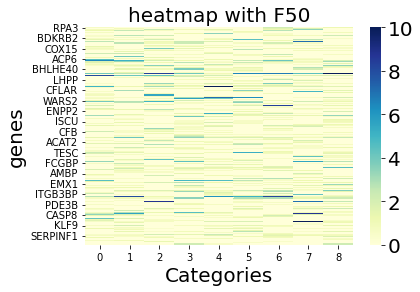

In [16]:
import pickle

qiu_guan_final=pd.read_csv('dataset/qiuguan/origin_800/LRP_aug/50/qiu_guan_all_names_new_df_2.csv',sep=',')#Y用基因编号而不是基因名，因为dict为基因编号
#print(qiu_guan_final)
qiu_guan_final=qiu_guan_final.iloc[:,1:]
row,col=qiu_guan_final.shape
print(row,col)
columns=np.array(qiu_guan_final).reshape(col).tolist()#if row doesn't work change col, otherwise replace col with row
#print(columns)



hot_np=np.zeros((col,9))#col or row  #########define a matrix,the row denotes the gene names and the column denotes the category ,in order to plot hot map
#print(hot_np.shape)
hot_df=pd.DataFrame(hot_np)
hot_df.index=columns
#print(hot_df)
#hot_np.
for i in range(9):   
    with open("dataset/qiuguan/origin_800/LRP_aug/50/dict/guan_genes_score_dict"+str(i)+".pkl", "rb") as tf:
        new_dict = pickle.load(tf)
        #print(new_dict)
        #keys=[i for i in new_dict.keys()]
        keys=new_dict.keys()
        #print(keys)
        key=[j for j in keys]
        values=new_dict.values()
        value=[j*100 for j in values]
        #print(value)
        hot_df.loc[key,i]=value
        #print(hot_df)
#print(hot_df)  
hot_df.to_csv('dataset/qiuguan/origin_800/LRP_aug/50/hot_df.csv')
##########从序号转换成基因名
import torch
import Trainer
from network import NFM
import torch.utils.data as Data
from Utils.criteo_loader import getTestData, getTrainData
import pandas as pd
import numpy as np
#train_val_info
#file_10477='dataset/qiuguan/origin_800/union_all_qiuguan.csv'
file_800='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/train_val_info.csv'#为了获取800的列名
#file_xiaoqiu='dataset/qiuguan/orign/xiaoguan/train_val_info.csv'#10477
#file_xiaoguan='dataset/qiuguan/orign/xiaoqiu/train_val_info.csv'#10477
#file_150='dataset/qiuguan/origin_800/LRP/hot_map/hot_df_iga_40_50_70_80.csv'

df_800=pd.read_csv(file_800,sep=',')#为了获取列名，为LRP特征基因寻找做列名，从管和球中选3301数据
df_800=df_800.iloc[:,1:]
#print(df_800)
#col_names=df_800.columns.values.tolist()
#print(col_names.shape)
#col_names.pop(-1)#删除label.1
#print(col_names)
#col_names.append('label')

#小球 处理，从10477中选3301 for800测试
#df_150=pd.read_csv(file_150,sep=',')
#df_150=df_150.iloc[:,1:]
#print(df_150)


col_names=hot_df.index
#col_names=[i+1 for i in col_names]
#print(col_names)


df_150_800=df_800.iloc[:,col_names]#必须是iloc

#print(df_150_800)


col_names=df_150_800.columns
##print(col_names)
hot_df.index=col_names

gene_names=pd.DataFrame(col_names)
gene_names.to_csv('dataset/qiuguan/origin_800/LRP_aug/50/gene_names_40.csv')
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import colorbar

tick_=np.arange(-20,20,5).astype(float)
dict_={'orientation':'vertical',"label":"color  \
scale","drawedges":True,"ticklocation":"right","extend":"min", \
"filled":True,"alpha":0.8,"cmap":"cmap","ticks":tick_,"spaci,linewidths=0.5ng":'proportional'}

#————————————————
#版权声明：本文为CSDN博主「黄思博呀」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
#原文链接：https://blog.csdn.net/Huang_8208_sibo/article/details/124699315
np.random.seed(0)
cmap=sns.heatmap(hot_df,vmin=0,vmax=10,cmap="YlGnBu")


#cmap = sns.heatmap(data,)
plt.xlabel("Categories",size=20)
plt.ylabel("genes",size=20,rotation=90)
plt.title("heatmap with F50",size=20)
 
#调整色带的标签：
cbar = cmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=20,labelcolor="black")
cbar.ax.set_ylabel(ylabel='',size=20,color="red",loc="center")
 
plt.show()
#————————————————
#版权声明：本文为CSDN博主「黄思博呀」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
#原文链接：https://blog.csdn.net/Huang_8208_sibo/article/details/124699315

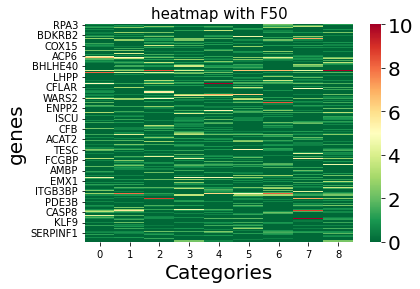

In [15]:
tick_=np.arange(-20,20,5).astype(float)
dict_={'orientation':'vertical',"label":"color  \
scale","drawedges":True,"ticklocation":"right","extend":"min", \
"filled":True,"alpha":0.8,"cmap":"cmap","ticks":tick_,"spaci,linewidths=0.5ng":'proportional'}

#————————————————
#版权声明：本文为CSDN博主「黄思博呀」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
#原文链接：https://blog.csdn.net/Huang_8208_sibo/article/details/124699315
np.random.seed(0)
cmap=sns.heatmap(hot_df,vmin=0,vmax=10,cmap="RdYlGn_r")########不同色系


#cmap = sns.heatmap(data,)
plt.xlabel("Categories",size=20)
plt.ylabel("genes",size=20,rotation=90)
plt.title("heatmap with F50",size=15)
 
#调整色带的标签：
cbar = cmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=20,labelcolor="black")
cbar.ax.set_ylabel(ylabel='',size=20,color="red",loc="center")
 
plt.show()
#————————————————

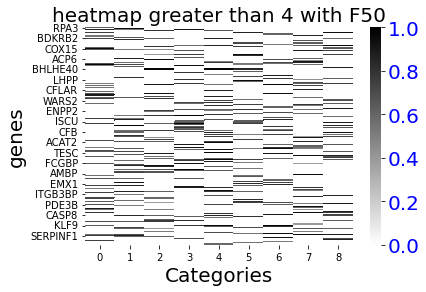

In [17]:
hot_map_df=hot_df

row,col=hot_map_df.shape
hot_map_df=np.array(hot_map_df)
#print(b)
for i, c in enumerate(hot_map_df):
    for j,k in enumerate(c):
        if k>=1:#####################
            hot_map_df[i,j]=0
hot_map_df=pd.DataFrame(hot_map_df)
hot_map_df.index=hot_df.index#########################
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import colorbar

tick_=np.arange(-20,20,5).astype(float)
dict_={'orientation':'vertical',"label":"color  \
scale","drawedges":True,"ticklocation":"right","extend":"min", \
"filled":True,"alpha":0.8,"cmap":"cmap","ticks":tick_,"spaci,linewidths=0.5ng":'proportional'}

#————————————————
#版权声明：本文为CSDN博主「黄思博呀」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
#原文链接：https://blog.csdn.net/Huang_8208_sibo/article/details/124699315
np.random.seed(0)
cmap=sns.heatmap(hot_map_df,vmin=0,vmax=1,cmap="binary")


#cmap = sns.heatmap(data,)
plt.xlabel("Categories",size=20)
plt.ylabel("genes",size=20,rotation=90)
plt.title("heatmap greater than 4 with F50",size=20)
 
#调整色带的标签：
cbar = cmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=20,labelcolor="blue")
cbar.ax.set_ylabel(ylabel='',size=20,color="red",loc="center")
 
plt.show()
